# Big Five Analysis Pipeline (Clean)

A fresh, structured notebook for evaluating game-based Big Five scores and training ML models on telemetry. Uses the same Google Sheet key and file paths as the original pipeline.

## Block 0 — Setup
Imports, theme, constants, and column groups reused from the previous pipeline.

In [25]:
import warnings
warnings.filterwarnings('ignore')

from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import gspread
from google.oauth2 import service_account

sns.set_theme(style='whitegrid', context='notebook')

GOOGLE_SHEET_KEY = '1lG0_Y_o2jl2rackWJyB1esAUcINb843PhNZBmTwf2L4'
SERVICE_ACCOUNT_FILE = 'genie-game.json'
SHEET_TELEMETRY = 'Sheet1'
SHEET_FACETS = 'OCEAN_Facets'

DATA_ROOT = Path('.')
SERVICE_ACCOUNT_PATH = DATA_ROOT / SERVICE_ACCOUNT_FILE

FACETS = [
    'Anxiety','Anger','Depression','SelfConsciousness','Immoderation','Vulnerability',
    'Friendliness','Gregariousness','Assertiveness','ActivityLevel','ExcitementSeeking','Cheerfulness',
    'Imagination','ArtisticInterests','Emotionality','Adventurousness','Intellect','Liberalism',
    'Trust','Morality','Altruism','Cooperation','Modesty','Sympathy',
    'SelfEfficacy','Orderliness','Dutifulness','AchievementStriving','SelfDiscipline','Cautiousness',
]

TRAIT_TO_FACETS = {
    'Openness': ['Imagination','ArtisticInterests','Emotionality','Adventurousness','Intellect','Liberalism'],
    'Conscientiousness': ['SelfEfficacy','Orderliness','Dutifulness','AchievementStriving','SelfDiscipline','Cautiousness'],
    'Extraversion': ['Friendliness','Gregariousness','Assertiveness','ActivityLevel','ExcitementSeeking','Cheerfulness'],
    'Agreeableness': ['Trust','Morality','Altruism','Cooperation','Modesty','Sympathy'],
    'Neuroticism': ['Anxiety','Anger','Depression','SelfConsciousness','Immoderation','Vulnerability'],
}

# Telemetry columns
RAW_TELEMETRY_COLS = [
    'TimeBeforeStart','FirstPathChoice','DecisionTime','CoinsRoomA','ChangedDirectionCount','IdleTime','HighFiveGiven',
    'TilesSteppedOnTrail','CoinsRoomB','SignificantDirectionChanges','InputJitterCount','RoomA_DurationSec',
    'RoomB_DurationSec','RoomC_DurationSec','JitterIntensity','AvgDirectionHoldMs','RoomADurationSec','PumpsCount',
    'BalloonExploded','CoinsCollectedBalloon','CoinsSaved','CoinsTotal','RoomB_NPC_Choice','RoomB_Decision_Time',
    'Balloon_Total_Pumps','Balloon_Explosions_Count','Balloon_Avg_Hesitation_Ms','Balloon_Avg_Cashout_Delay_Ms',
    'Balloon_Post_Explosion_Ratio','Balloon_Risk_Variability','AvatarChosen','AvatarChoiceTimeMs','AvatarHoverCount',
    'AvatarClickCount','AvatarShapeType','AvatarColorCategory','AvatarFinalHesitationMs','PumpCountBeforeSound_Mean',
    'PumpSpeedBeforeSound_Mean','PumpRhythmVarianceBefore_Mean','PumpSpeedAfterSound_Mean','PumpRhythmVarianceAfter_Mean',
    'ExtraPumpsAfterSound_Mean','TimeToFirstActionAfterSound_Mean','PumpSpeedChangeRatio_Mean','RhythmStabilityChange_Mean',
    'StrategyShiftFlag_Pct','NearPopCoinsSavedAfterSound_Sum','NearPopCoinsLostAfterSound_Sum','NearPopRoundsWithSound'
]

IDENTIFIER_COLS = ['PlayerID','Big5TestID','Timestamp']

CATEGORICAL_RAW_COLS = [
    'FirstPathChoice','JitterIntensity','RoomB_NPC_Choice','AvatarChosen','AvatarShapeType','AvatarColorCategory'
]

NUMERIC_RAW_COLS = [c for c in RAW_TELEMETRY_COLS if c not in CATEGORICAL_RAW_COLS]

RANDOM_STATE = 42
TEST_SIZE = 0.2


## Block 1 — Load Data
Connect to Google Sheets (same key and credential file as before), coerce numeric fields, and keep only rows with all true Trait_* values present.

In [26]:
def load_sheet_data(use_google: bool = True):
    if use_google:
        scopes = ['https://spreadsheets.google.com/feeds','https://www.googleapis.com/auth/drive']
        creds = service_account.Credentials.from_service_account_file(
            SERVICE_ACCOUNT_PATH,
            scopes=scopes,
        )
        client = gspread.authorize(creds)
        sh = client.open_by_key(GOOGLE_SHEET_KEY)
        tele_ws = sh.worksheet(SHEET_TELEMETRY)
        facets_ws = sh.worksheet(SHEET_FACETS)
        header_tele = [h for h in tele_ws.row_values(1) if str(h).strip()]
        header_facets = [h for h in facets_ws.row_values(1) if str(h).strip()]
        tele = pd.DataFrame(tele_ws.get_all_records(expected_headers=header_tele))
        facets = pd.DataFrame(facets_ws.get_all_records(expected_headers=header_facets))
    else:
        raise SystemExit('CSV fallback not configured for new schema')
    return tele, facets


def coerce_numeric(df: pd.DataFrame, columns: list[str]) -> pd.DataFrame:
    for col in columns:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')
    return df

tele_df_raw, facets_df_raw = load_sheet_data(use_google=True)
print(f'Telemetry shape: {tele_df_raw.shape}, facets sheet shape: {facets_df_raw.shape}')

# basic cleanup
tele_df_raw.columns = [c.strip() for c in tele_df_raw.columns]
facets_df_raw.columns = [c.strip() for c in facets_df_raw.columns]
tele_df_raw.replace({'': np.nan, ' ': np.nan}, inplace=True)
facets_df_raw.replace({'': np.nan, ' ': np.nan}, inplace=True)

# keep only intersections
tele_features = [c for c in RAW_TELEMETRY_COLS if c in tele_df_raw.columns]
facet_real_cols = [f'Facet_{f}_Real' for f in FACETS if f'Facet_{f}_Real' in facets_df_raw.columns]
facet_pred_cols = [f'Facet_{f}_Pred' for f in FACETS if f'Facet_{f}_Pred' in facets_df_raw.columns]

numeric_candidates = [c for c in tele_features if c not in CATEGORICAL_RAW_COLS]
tele_df = coerce_numeric(tele_df_raw.copy(), numeric_candidates)
facets_df = coerce_numeric(facets_df_raw.copy(), facet_real_cols + facet_pred_cols)

# join
merged = pd.merge(tele_df, facets_df, on=['PlayerID','Big5TestID'], how='inner')
print(f'Merged shape (inner on IDs): {merged.shape}')

# drop rows without full real facets
merged = merged.dropna(subset=facet_real_cols, how='any').reset_index(drop=True)
print(f'After dropping incomplete real facets: {merged.shape}')

# compute real trait sums from facets
for trait, facets in TRAIT_TO_FACETS.items():
    merged[f'Trait_{trait}_Real'] = merged[[f'Facet_{f}_Real' for f in facets]].sum(axis=1)

if facet_pred_cols:
    for trait, facets in TRAIT_TO_FACETS.items():
        cols = [f'Facet_{f}_Pred' for f in facets if f'Facet_{f}_Pred' in merged.columns]
        if cols:
            merged[f'Trait_{trait}_Pred'] = merged[cols].sum(axis=1)

merged.head()


Telemetry shape: (7, 53), facets sheet shape: (70, 79)
Merged shape (inner on IDs): (7, 130)
After dropping incomplete real facets: (7, 130)


,PlayerID,Big5TestID,TimeBeforeStart,FirstPathChoice,DecisionTime,CoinsRoomA,ChangedDirectionCount,IdleTime,HighFiveGiven,TilesSteppedOnTrail,...,Facet_AchievementStriving_Pred,Facet_SelfDiscipline_Pred,Facet_Cautiousness_Pred,,Trait_Openness_Error,Trait_Conscientiousness_Error,Trait_Extraversion_Error,Trait_Agreeableness_Error,Trait_Neuroticism_Error,Facet_Total_Error
0,Max,6903765610ac331e1bd0edc5,3.41,upward,83.05,6,0,43.35,1,24,...,18.0,16.0,18.0,NaN,2.0,16.0,12.0,14.0,3.0,140.0
1,Anton,691cc5711acd3ebc317285cb,27.93,lit,97.99,0,0,64.67,0,27,...,11.0,12.0,14.0,NaN,16.0,4.0,28.0,38.0,20.0,240.0
2,Ilia,6907134ab2abf2e2002bc740,17.84,upward,156.13,5,0,67.75,1,26,...,18.0,16.0,20.0,NaN,5.0,17.0,9.0,11.0,22.0,172.0
3,Margo,6926b7062aa721ec246267bf,12.97,foggy,109.92,3,0,66.34,1,17,...,12.0,12.0,20.0,NaN,2.0,4.0,16.0,6.0,2.0,156.0
4,Dima,669d25ebc89919717e7fe1bb,52.32,upward,141.23,5,0,97.77,0,13,...,20.0,16.0,14.0,NaN,9.0,17.0,4.0,14.0,7.0,162.0


## Block 2 — Compare Game Big Five vs True Big Five
Compute MAE, RMSE, and Pearson correlation for each trait; build an error table; and visualize the alignment between game scores and true Trait_* scores.

In [27]:
# Baseline: rulebook predictions (if present)
rule_facet_metrics = []
rule_trait_metrics = []

if any(c.endswith('_Pred') for c in merged.columns):
    for facet in FACETS:
        real_col = f'Facet_{facet}_Real'
        pred_col = f'Facet_{facet}_Pred'
        if real_col in merged and pred_col in merged:
            pair = merged[[real_col, pred_col]].dropna()
            if pair.empty:
                continue
            mae = mean_absolute_error(pair[real_col], pair[pred_col])
            rmse = np.sqrt(mean_squared_error(pair[real_col], pair[pred_col]))
            rule_facet_metrics.append({'Facet': facet, 'MAE': mae, 'RMSE': rmse})
    rule_facet_df = pd.DataFrame(rule_facet_metrics)

    # trait sums from rulebook facets
    for trait, facets in TRAIT_TO_FACETS.items():
        real_cols = [f'Facet_{f}_Real' for f in facets if f'Facet_{f}_Real' in merged]
        pred_cols = [f'Facet_{f}_Pred' for f in facets if f'Facet_{f}_Pred' in merged]
        if real_cols and pred_cols:
            merged[f'Trait_{trait}_Rulebook'] = merged[pred_cols].sum(axis=1)
            merged[f'Trait_{trait}_Real_sum'] = merged[real_cols].sum(axis=1)
            mae = mean_absolute_error(merged[f'Trait_{trait}_Real_sum'], merged[f'Trait_{trait}_Rulebook'])
            rmse = np.sqrt(mean_squared_error(merged[f'Trait_{trait}_Real_sum'], merged[f'Trait_{trait}_Rulebook']))
            rule_trait_metrics.append({'Trait': trait, 'MAE': mae, 'RMSE': rmse})
    rule_trait_df = pd.DataFrame(rule_trait_metrics)
else:
    print('No *_Pred columns found for rulebook baseline')


In [28]:
rule_facet_df if 'rule_facet_df' in globals() else None

,Facet,MAE,RMSE
0,Anxiety,5.000000,5.567764
1,Anger,1.857143,2.420153
2,Depression,3.285714,3.683942
3,SelfConsciousness,3.142857,3.505098
4,Immoderation,4.142857,4.358899
5,Vulnerability,2.285714,2.672612
6,Friendliness,3.571429,4.225771
7,Gregariousness,3.857143,4.675162
8,Assertiveness,3.142857,3.703280
9,ActivityLevel,2.285714,2.672612


In [29]:
rule_trait_df if 'rule_trait_df' in globals() else None

,Trait,MAE,RMSE
0,Openness,9.000000,10.790207
1,Conscientiousness,13.000000,14.257830
2,Extraversion,13.714286,15.390164
3,Agreeableness,13.714286,17.328754
4,Neuroticism,9.714286,12.224098


In [30]:
print('Plots are skipped in this pared-down pipeline (dataset is tiny).')

Plots are skipped in this pared-down pipeline (dataset is tiny).


## Block 3 — Prepare Data for Machine Learning
Drop Game OCEAN columns, keep only raw telemetry as features, one-hot encode categorical signals, scale numerics, and create a reusable preprocessing pipeline.

In [31]:
available_raw_features = [c for c in RAW_TELEMETRY_COLS if c in merged.columns]
available_categorical = [c for c in CATEGORICAL_RAW_COLS if c in merged.columns]
available_numeric = [c for c in available_raw_features if c not in available_categorical]

preprocess = ColumnTransformer(
    transformers=[
        (
            'num',
            Pipeline([
                ('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler()),
            ]),
            available_numeric,
        ),
        (
            'cat',
            Pipeline([
                ('imputer', SimpleImputer(strategy='most_frequent')),
                ('onehot', OneHotEncoder(handle_unknown='ignore')),
            ]),
            available_categorical,
        ),
    ],
    remainder='drop',
)

print('Numeric features:', available_numeric)
print('Categorical features:', available_categorical)


Numeric features: ['TimeBeforeStart', 'DecisionTime', 'CoinsRoomA', 'ChangedDirectionCount', 'IdleTime', 'HighFiveGiven', 'TilesSteppedOnTrail', 'CoinsRoomB', 'SignificantDirectionChanges', 'InputJitterCount', 'RoomA_DurationSec', 'RoomB_DurationSec', 'RoomC_DurationSec', 'AvgDirectionHoldMs', 'RoomADurationSec', 'PumpsCount', 'BalloonExploded', 'CoinsCollectedBalloon', 'CoinsSaved', 'CoinsTotal', 'RoomB_Decision_Time', 'Balloon_Total_Pumps', 'Balloon_Explosions_Count', 'Balloon_Avg_Hesitation_Ms', 'Balloon_Avg_Cashout_Delay_Ms', 'Balloon_Post_Explosion_Ratio', 'Balloon_Risk_Variability', 'AvatarChoiceTimeMs', 'AvatarHoverCount', 'AvatarClickCount', 'AvatarFinalHesitationMs', 'PumpCountBeforeSound_Mean', 'PumpSpeedBeforeSound_Mean', 'PumpRhythmVarianceBefore_Mean', 'PumpSpeedAfterSound_Mean', 'PumpRhythmVarianceAfter_Mean', 'ExtraPumpsAfterSound_Mean', 'TimeToFirstActionAfterSound_Mean', 'PumpSpeedChangeRatio_Mean', 'RhythmStabilityChange_Mean', 'StrategyShiftFlag_Pct', 'NearPopCoinsSa

## Block 4 — Train ML Models
Train Linear Regression, Ridge, Random Forest, and Gradient Boosting for each trait using only telemetry features. Evaluate MAE, RMSE, and R², and pick the best model per trait.

In [32]:
model_zoo = {
    'LinearRegression': LinearRegression(),
    'Ridge': Ridge(alpha=1.0),
    'RandomForest': RandomForestRegressor(n_estimators=300, random_state=RANDOM_STATE, n_jobs=-1),
    'GradientBoosting': GradientBoostingRegressor(random_state=RANDOM_STATE),
}

ml_results = {}
facet_metrics_summary = []
pred_table = pd.DataFrame()

for facet in FACETS:
    target_col = f'Facet_{facet}_Real'
    if target_col not in merged.columns:
        continue

    usable = merged.dropna(subset=[target_col])
    if len(usable) < 2:
        continue

    X = usable[available_raw_features]
    y = usable[target_col]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE
    )

    best_name = None
    best_mae = np.inf
    best_record = None
    stored_models = {}

    for name, estimator in model_zoo.items():
        pipeline = Pipeline([
            ('preprocess', preprocess),
            ('model', estimator),
        ])
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)

        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)

        stored_models[name] = {'pipeline': pipeline, 'y_pred': y_pred, 'y_test': y_test}

        if mae < best_mae:
            best_mae = mae
            best_name = name
            best_record = {'Facet': facet, 'Model': name, 'MAE': mae, 'RMSE': rmse, 'R2': r2}

    if best_record is None:
        continue

    # fit best model on all data and predict full set for aggregation
    best_pipeline = Pipeline([
        ('preprocess', preprocess),
        ('model', model_zoo[best_name]),
    ])
    best_pipeline.fit(X, y)
    pred_full = best_pipeline.predict(merged[available_raw_features])
    pred_table[f'Facet_{facet}_Pred_ML'] = pred_full

    ml_results[facet] = {
        'best_model': best_name,
        'best_record': best_record,
        'stored_models': stored_models,
    }
    facet_metrics_summary.append(best_record)

facet_metrics_df = pd.DataFrame(facet_metrics_summary)
facet_metrics_df


,Facet,Model,MAE,RMSE,R2
0,Anxiety,RandomForest,1.711667,1.796337,-0.434146
1,Anger,Ridge,0.762955,0.785251,0.725947
2,Depression,RandomForest,2.050000,2.801892,-2.489156
3,SelfConsciousness,RandomForest,1.713333,2.097525,-0.955383
4,Immoderation,Ridge,2.074076,2.468318,0.025185
5,Vulnerability,RandomForest,0.958333,1.209768,-0.463539
6,Friendliness,RandomForest,1.255000,1.400534,-0.961494
7,Gregariousness,RandomForest,3.005000,4.054318,-1.629999
8,Assertiveness,RandomForest,0.775000,1.047688,-3.390600
9,ActivityLevel,RandomForest,2.200000,2.634862,-0.735625


In [33]:
# Aggregate predicted facets into traits and evaluate
if not pred_table.empty:
    trait_pred_rows = []
    trait_real_rows = []
    for trait, facets in TRAIT_TO_FACETS.items():
        cols_ml = [f'Facet_{f}_Pred_ML' for f in facets if f'Facet_{f}_Pred_ML' in pred_table.columns]
        cols_real = [f'Facet_{f}_Real' for f in facets if f'Facet_{f}_Real' in merged.columns]
        if cols_ml and cols_real:
            merged[f'Trait_{trait}_Pred_ML'] = pred_table[cols_ml].sum(axis=1)
            merged[f'Trait_{trait}_Real_sum'] = merged[cols_real].sum(axis=1)
    trait_metrics = []
    for trait in TRAIT_TO_FACETS:
        pred_col = f'Trait_{trait}_Pred_ML'
        real_col = f'Trait_{trait}_Real_sum'
        if pred_col in merged and real_col in merged:
            mae = mean_absolute_error(merged[real_col], merged[pred_col])
            rmse = np.sqrt(mean_squared_error(merged[real_col], merged[pred_col]))
            trait_metrics.append({'Trait': trait, 'MAE': mae, 'RMSE': rmse})
    trait_metrics_df = pd.DataFrame(trait_metrics)
    display(trait_metrics_df)
else:
    print('No ML predictions to aggregate')


,Trait,MAE,RMSE
0,Openness,1.792936,2.038314
1,Conscientiousness,2.176311,2.605872
2,Extraversion,2.084474,2.425958
3,Agreeableness,2.406752,2.515336
4,Neuroticism,2.493684,3.391219


In [34]:
# Per-facet model comparison tables (best only)
if facet_metrics_df.empty:
    print('No ML results (not enough data).')
else:
    display(facet_metrics_df.sort_values(['MAE']))

,Facet,Model,MAE,RMSE,R2
11,Cheerfulness,Ridge,0.347471,0.431187,0.814078
22,Modesty,GradientBoosting,0.605383,0.654393,0.000000
20,Altruism,GradientBoosting,0.651523,0.869559,-2.024529
1,Anger,Ridge,0.762955,0.785251,0.725947
8,Assertiveness,RandomForest,0.775000,1.047688,-3.390600
15,Adventurousness,RandomForest,0.798333,0.989728,0.020439
5,Vulnerability,RandomForest,0.958333,1.209768,-0.463539
10,ExcitementSeeking,GradientBoosting,1.019558,1.141111,0.674467
28,SelfDiscipline,LinearRegression,1.173869,1.643157,-0.199985
13,ArtisticInterests,RandomForest,1.176667,1.395365,0.134647


## Block 5 — Feature Importance
For tree models (Random Forest / Gradient Boosting), extract and plot the top-10 contributing telemetry features for each trait.

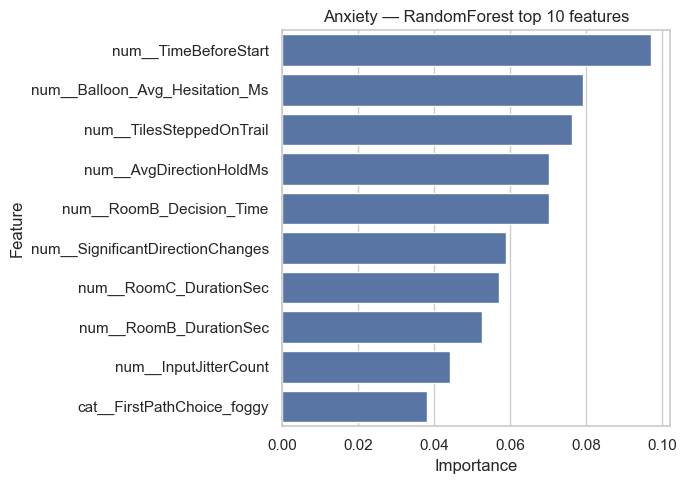

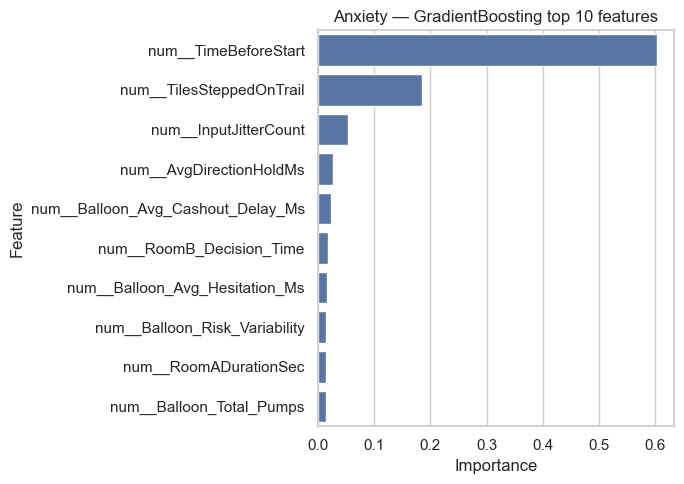

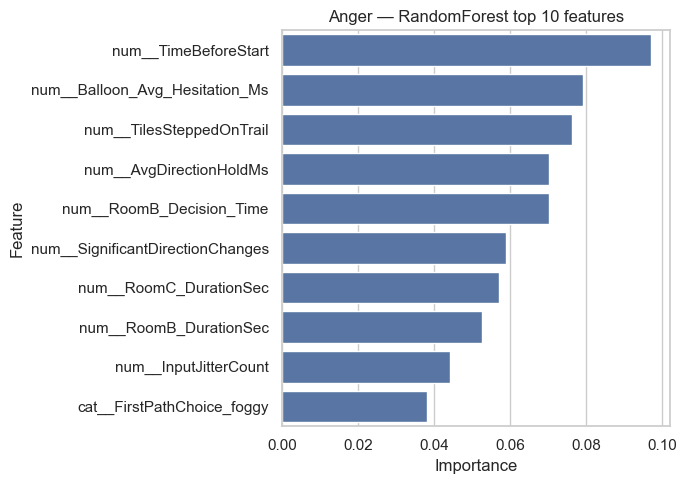

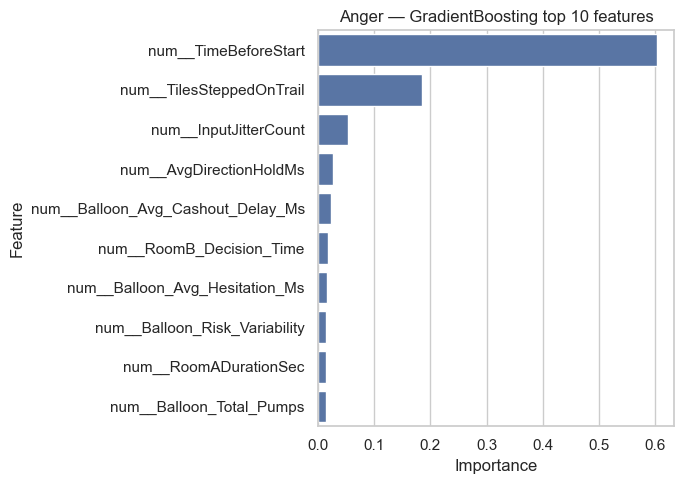

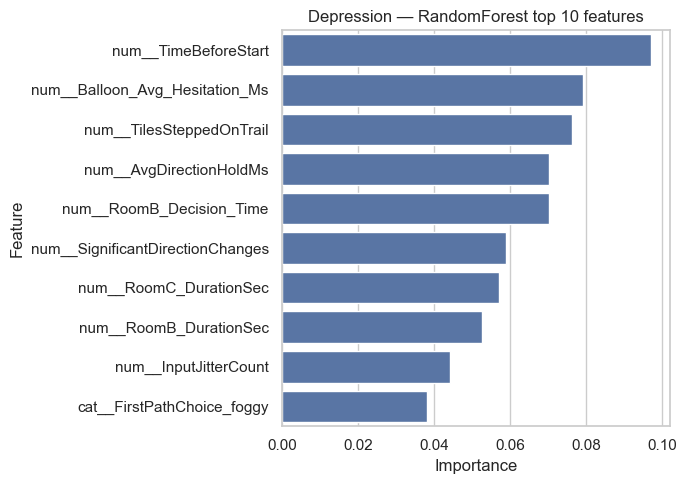

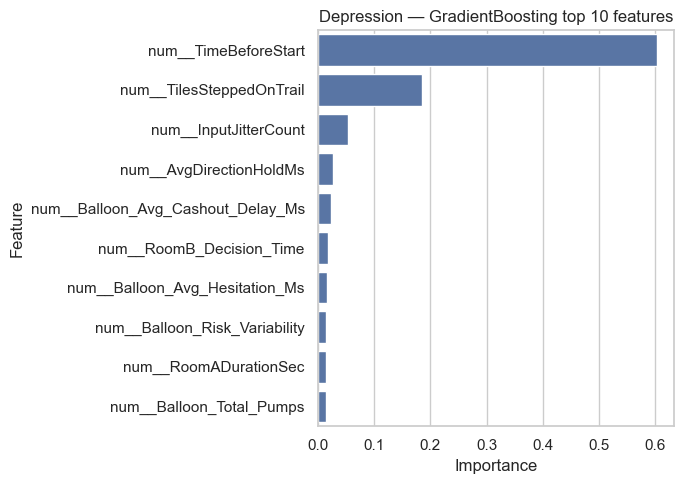

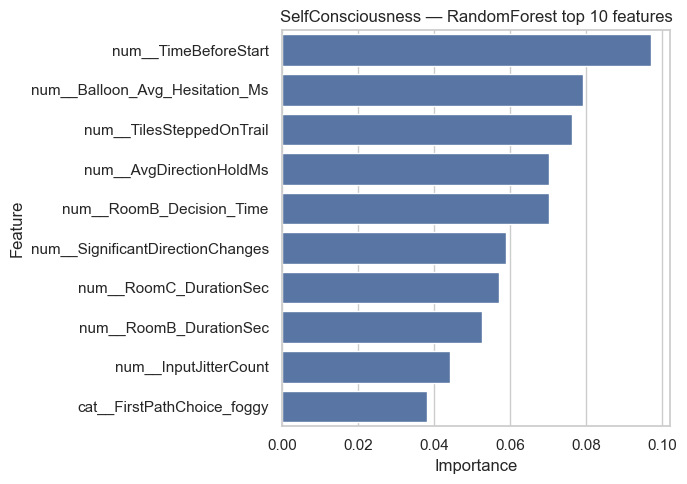

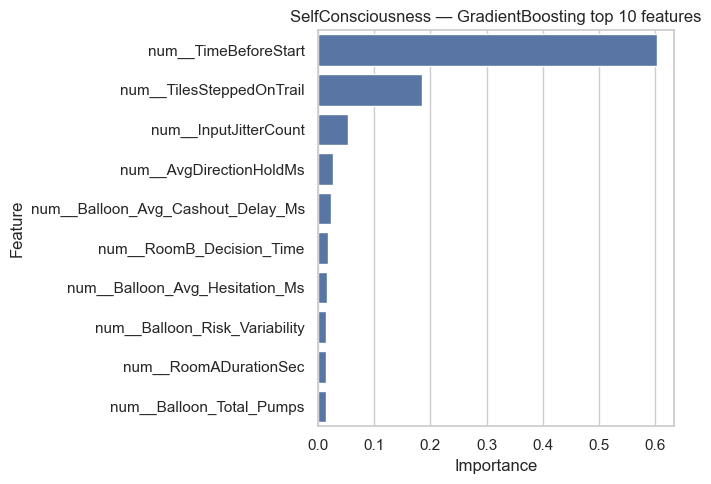

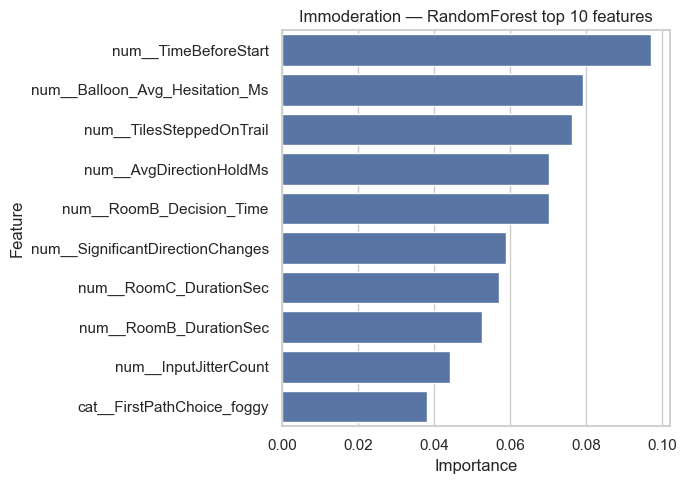

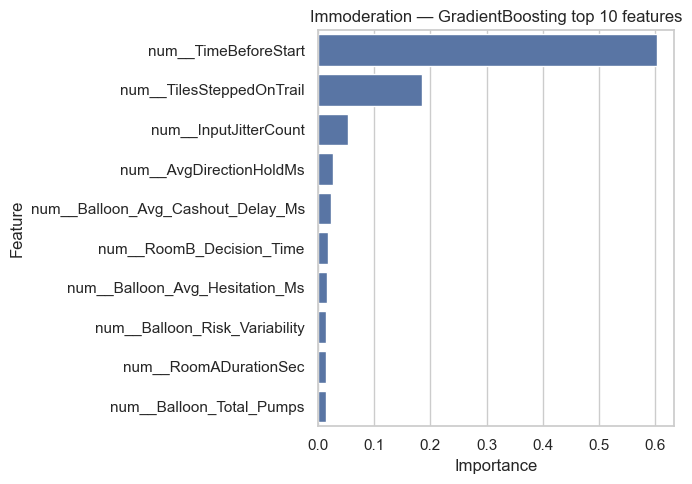

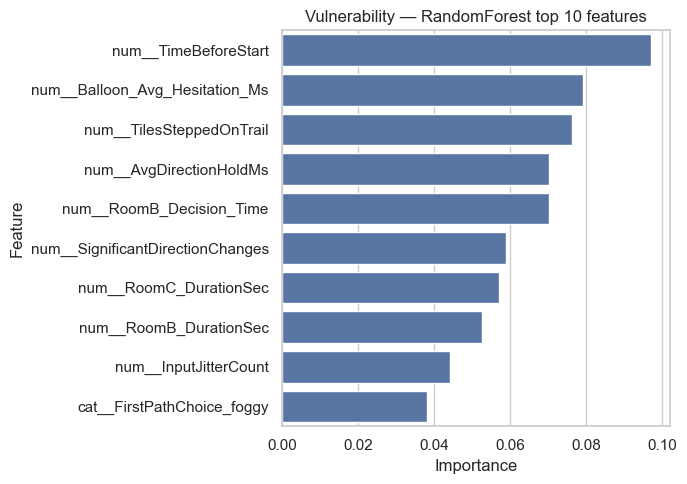

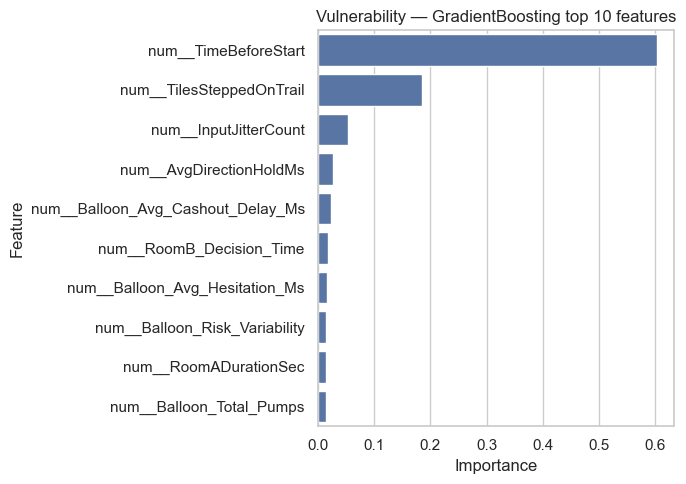

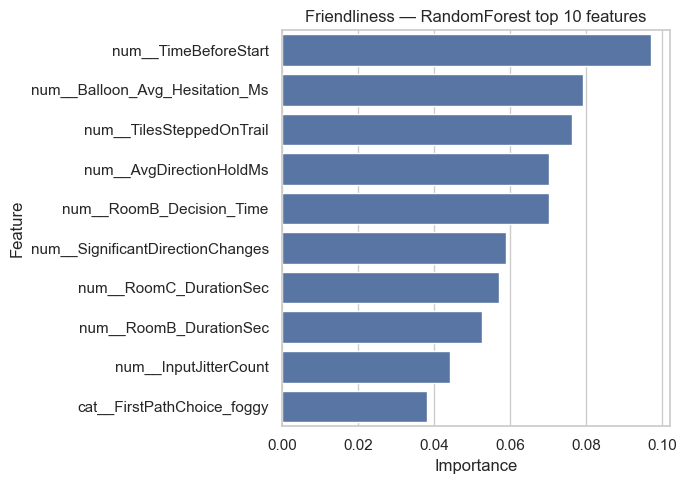

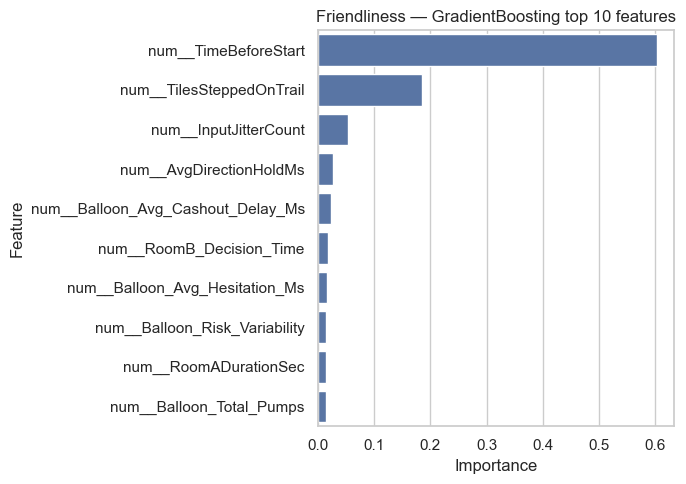

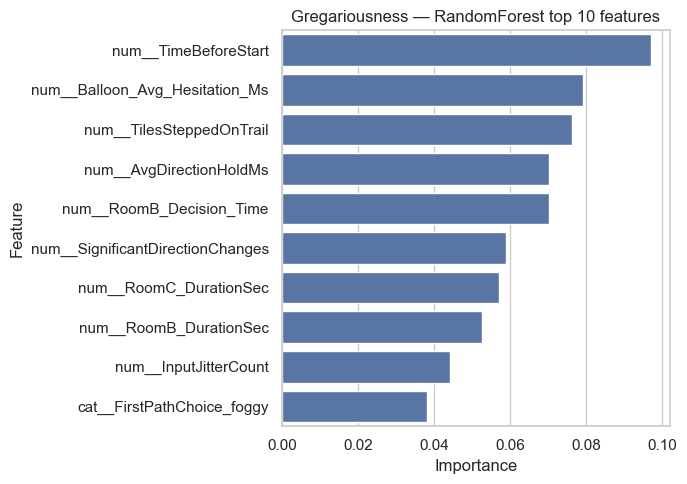

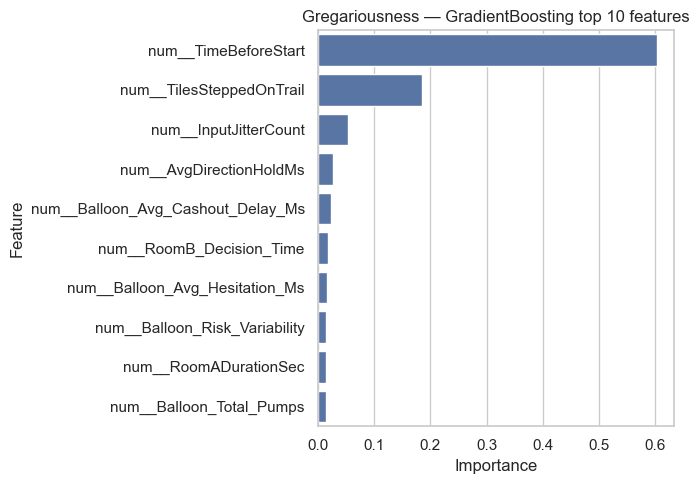

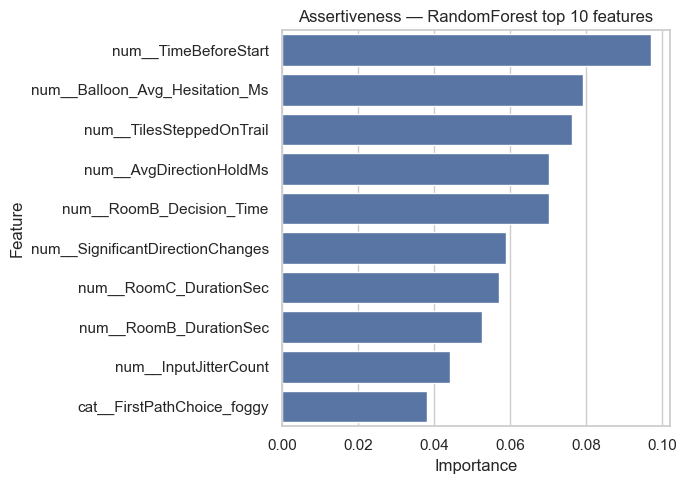

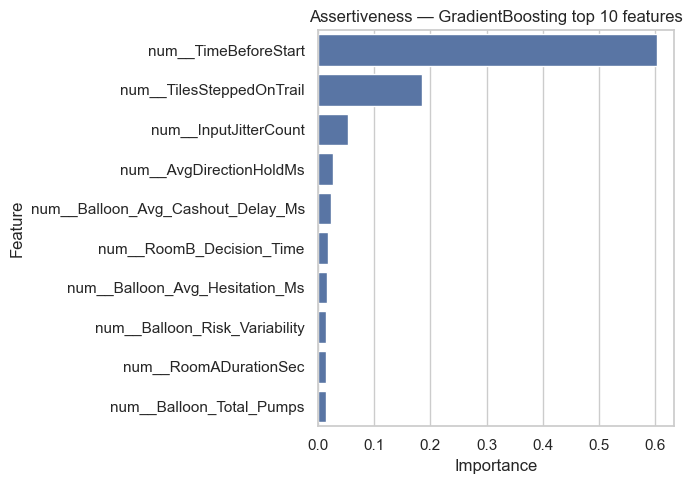

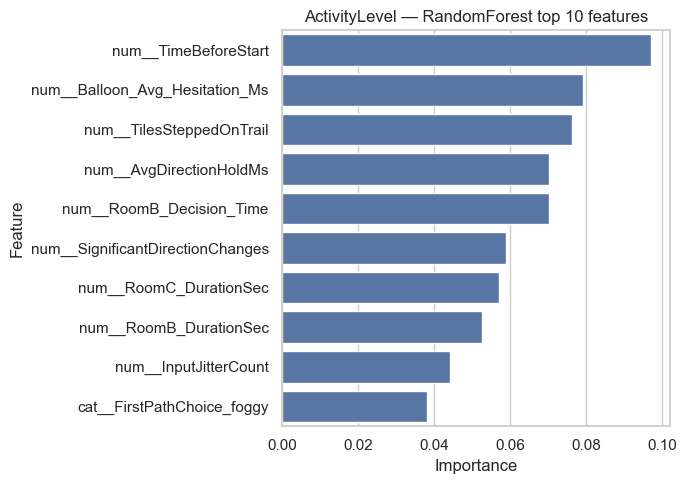

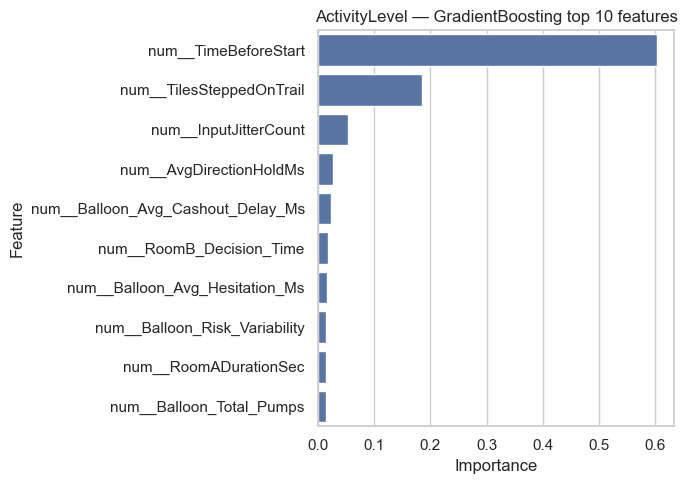

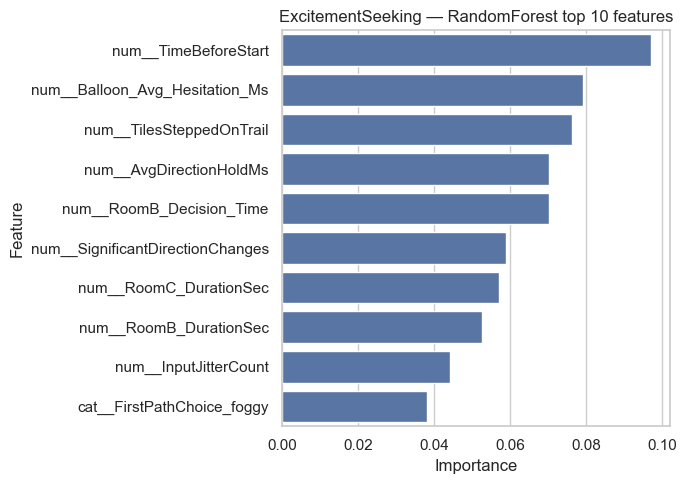

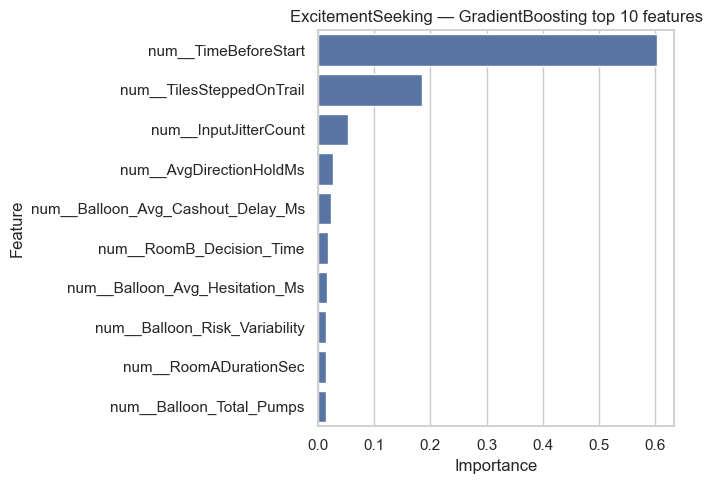

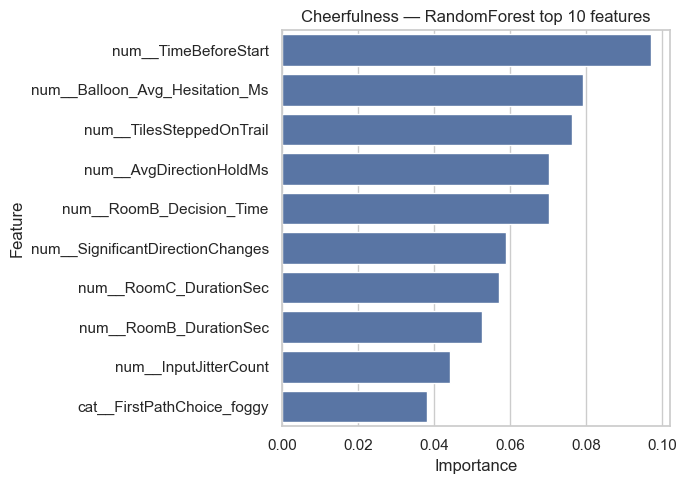

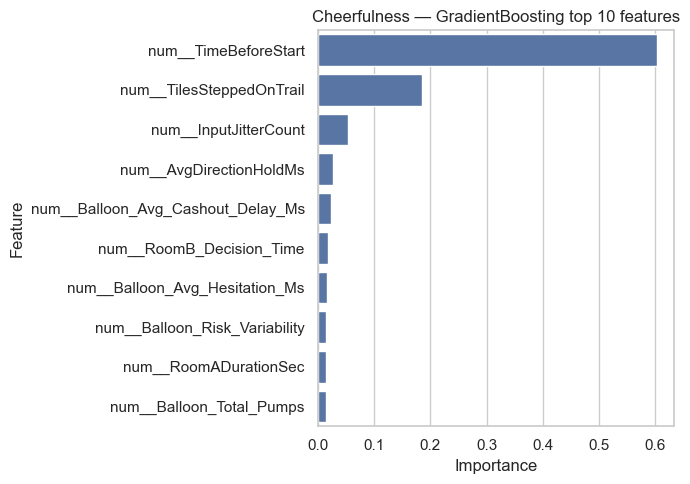

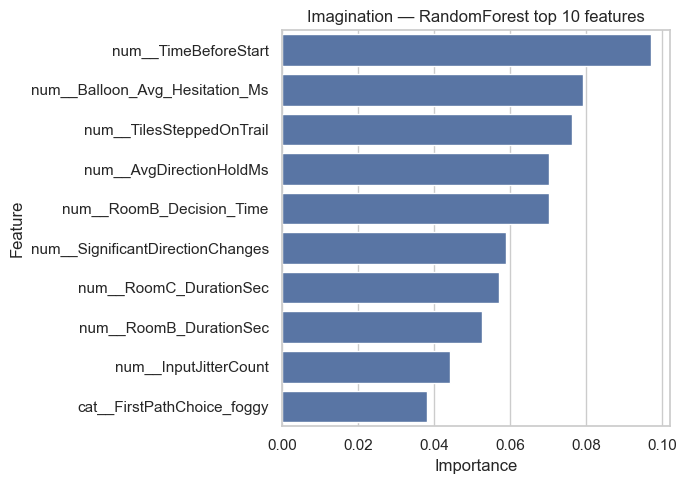

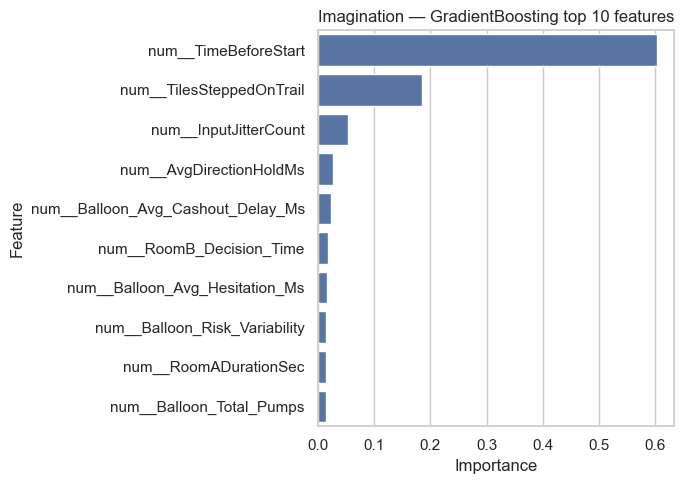

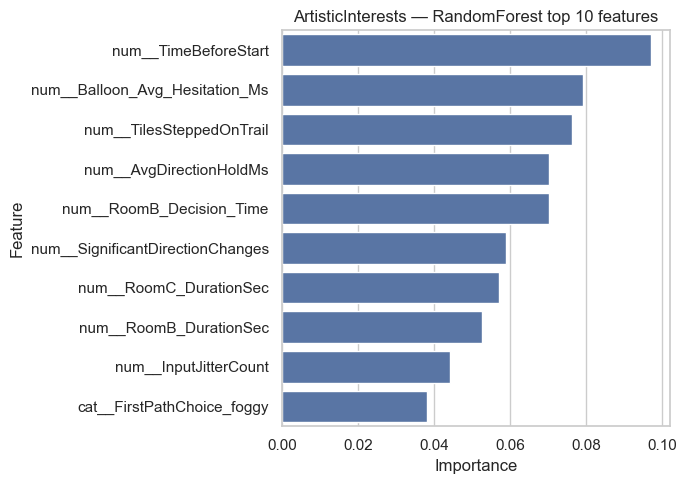

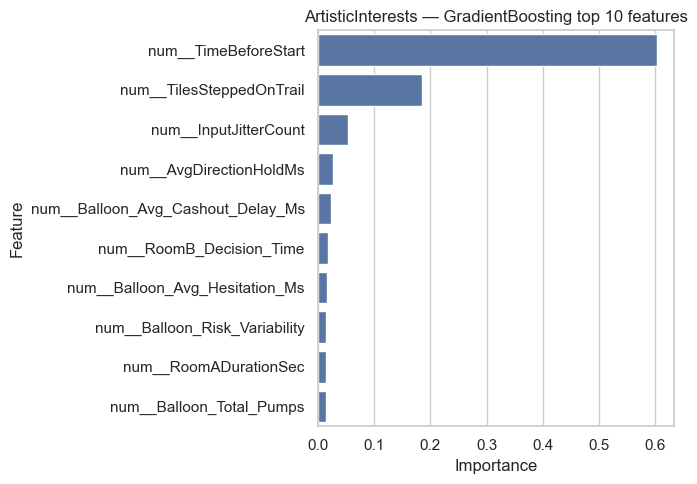

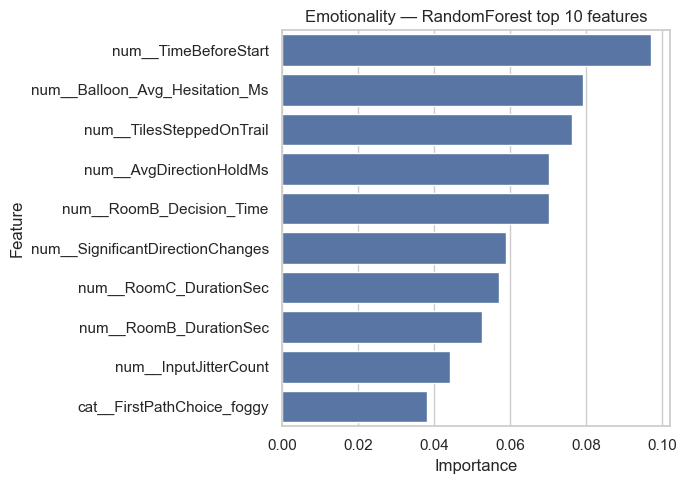

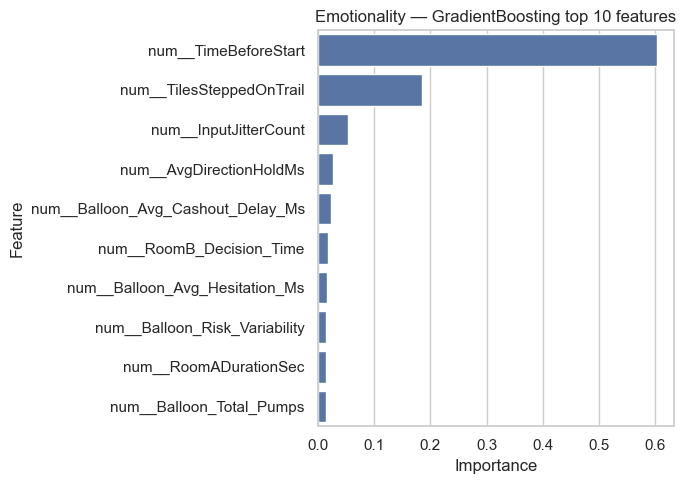

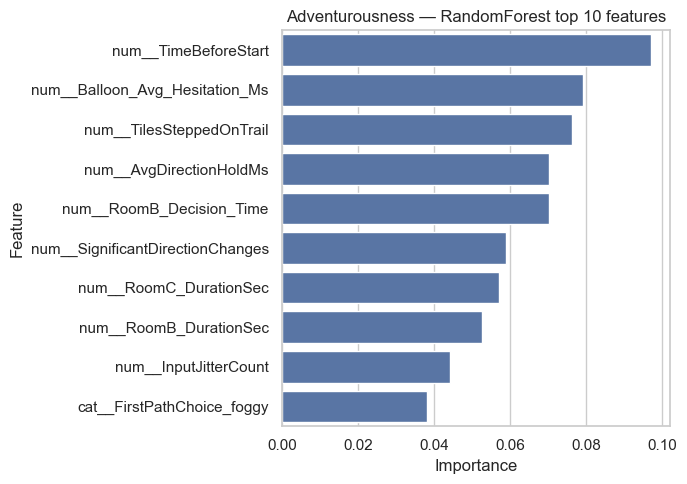

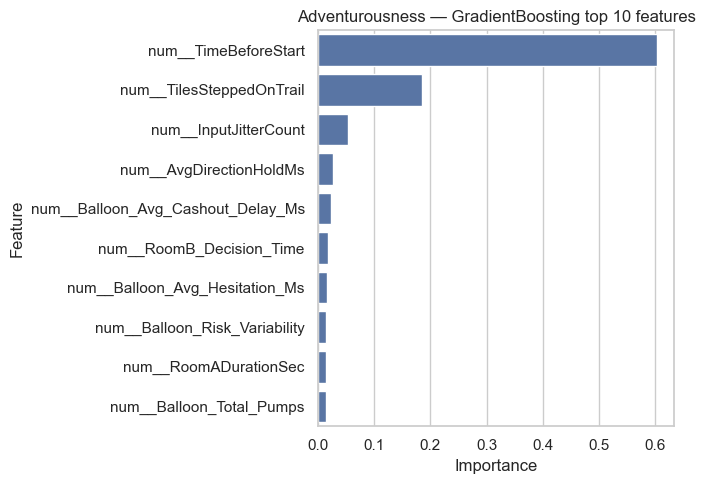

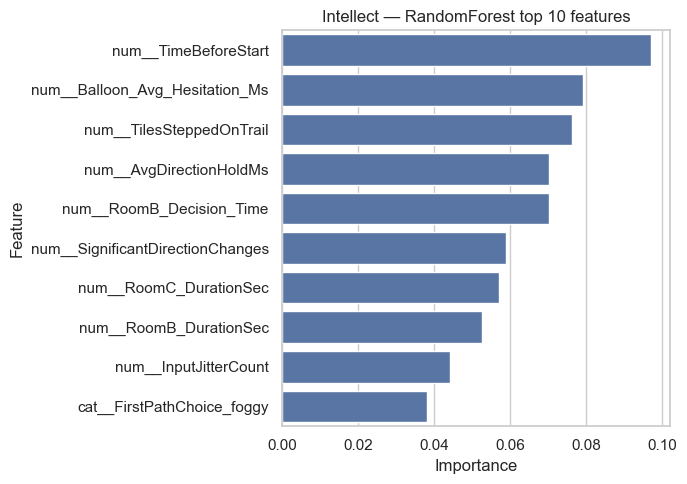

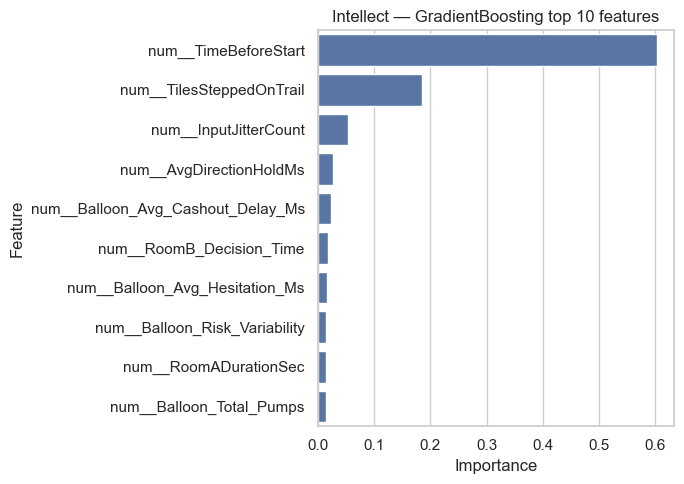

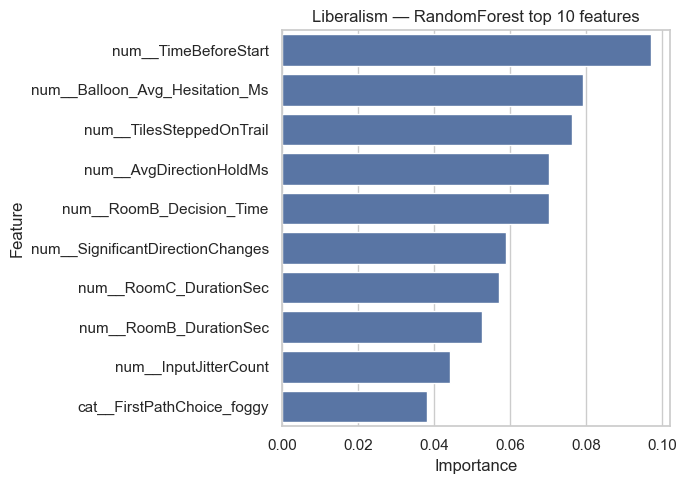

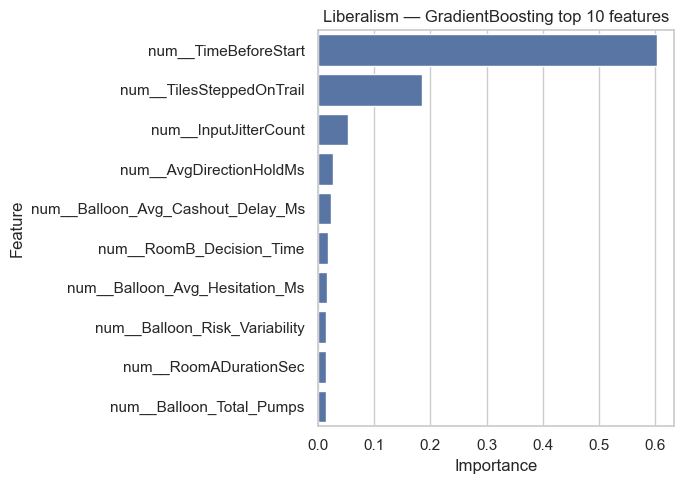

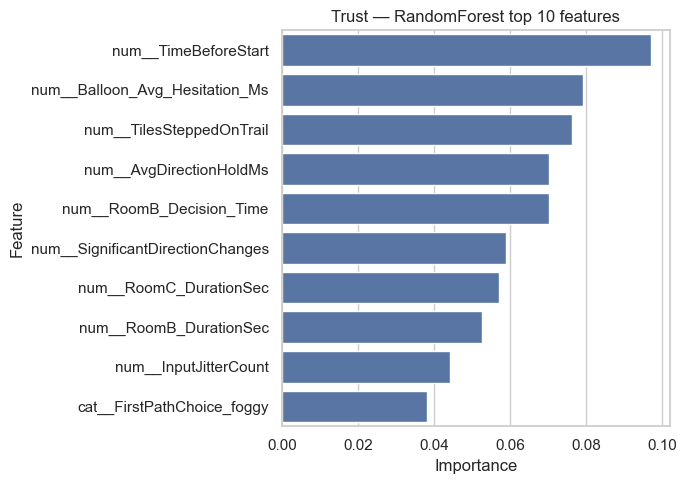

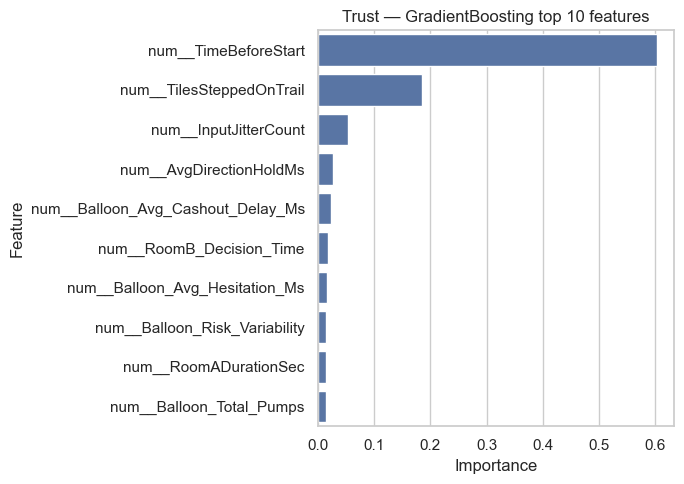

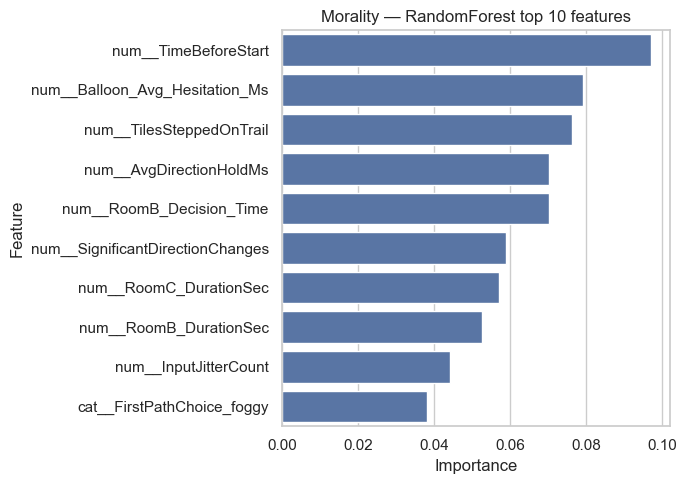

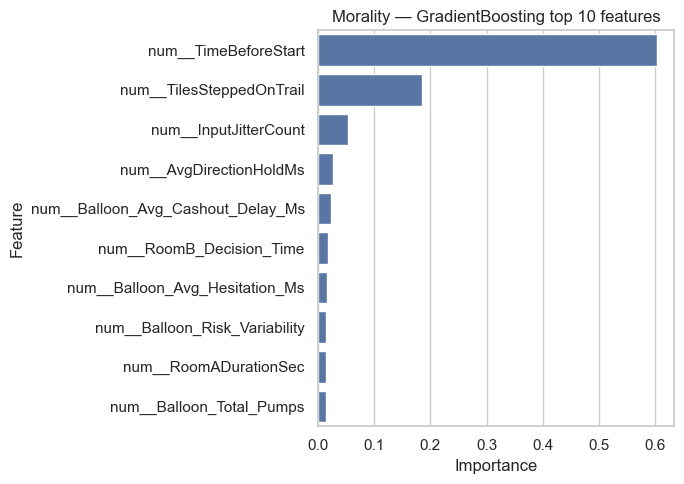

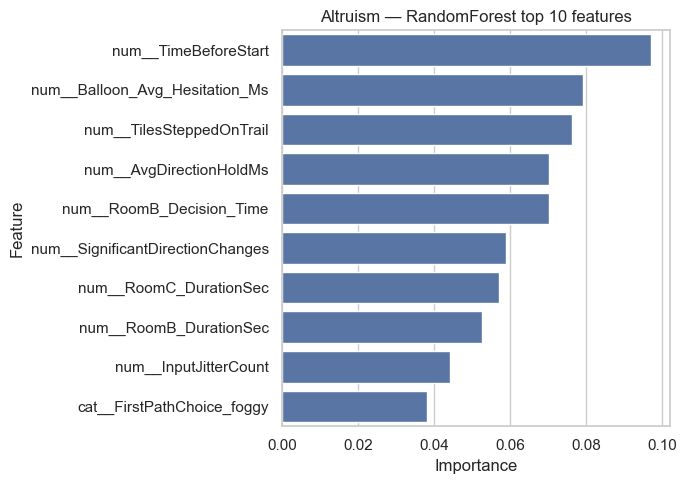

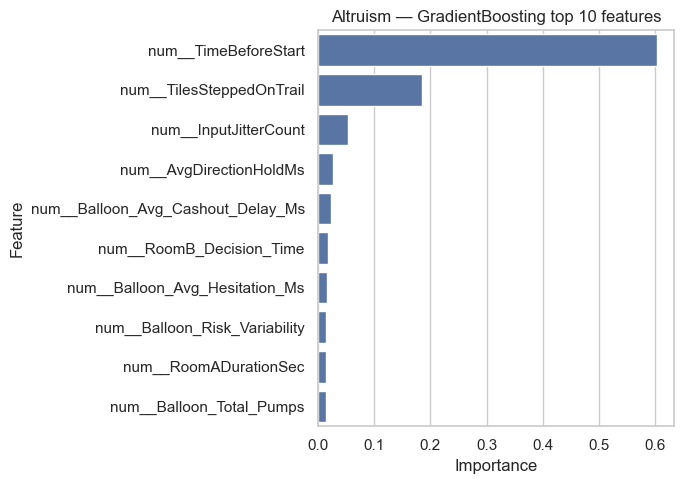

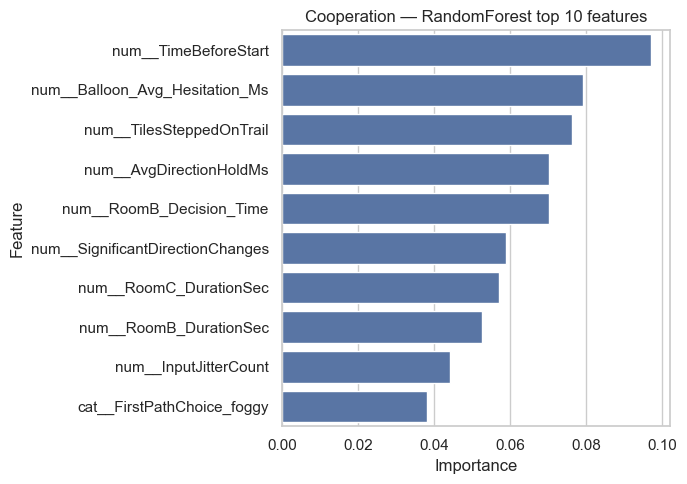

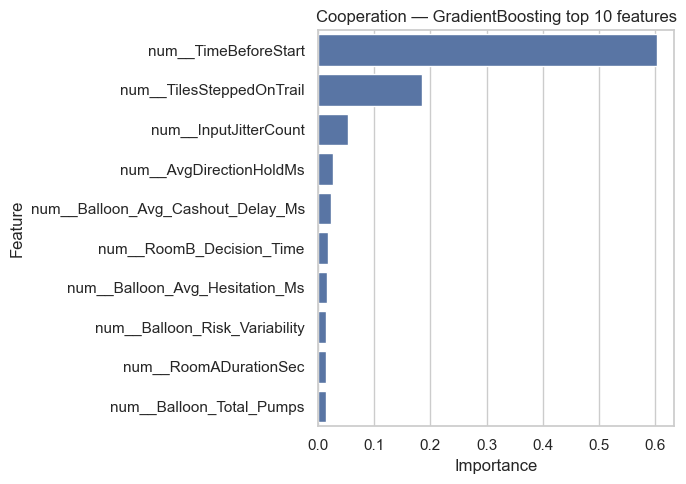

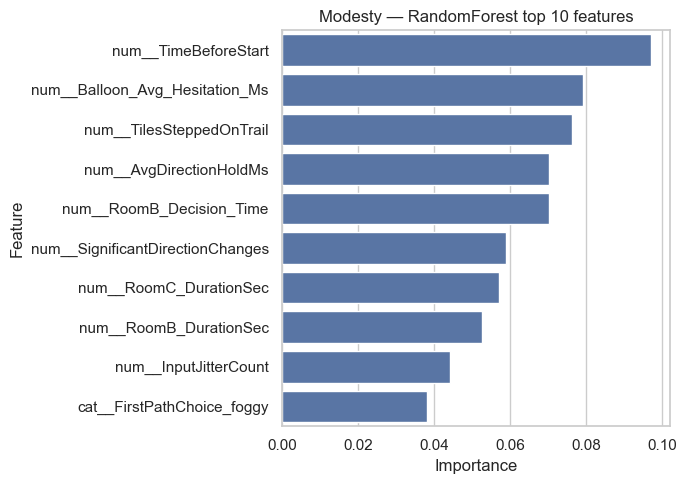

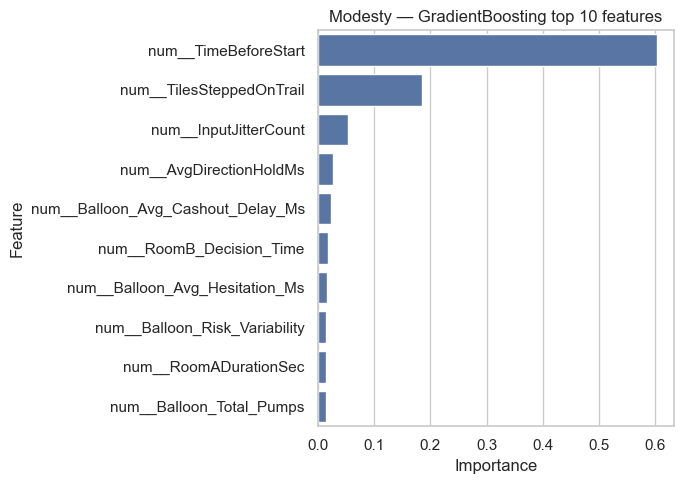

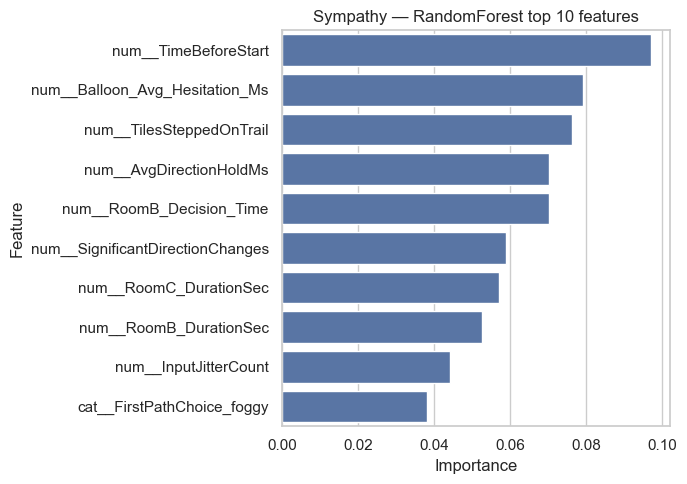

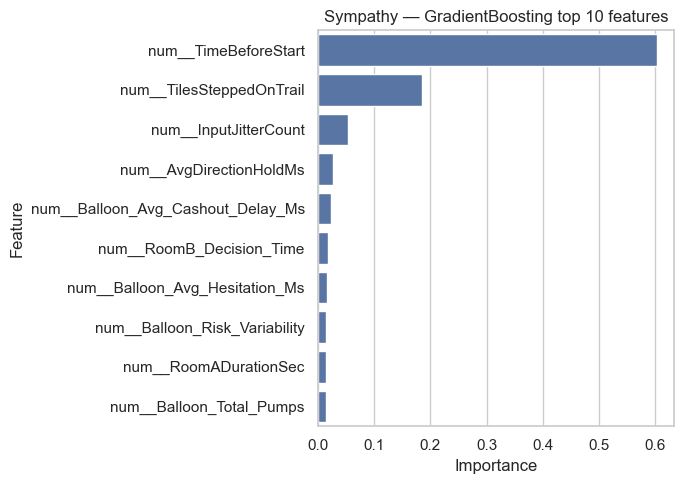

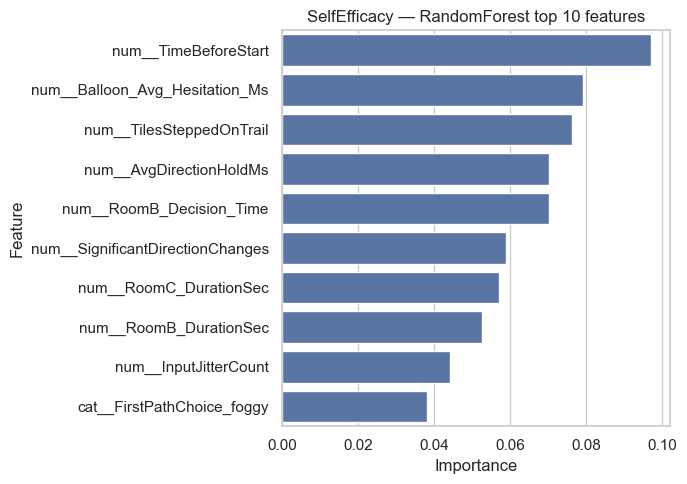

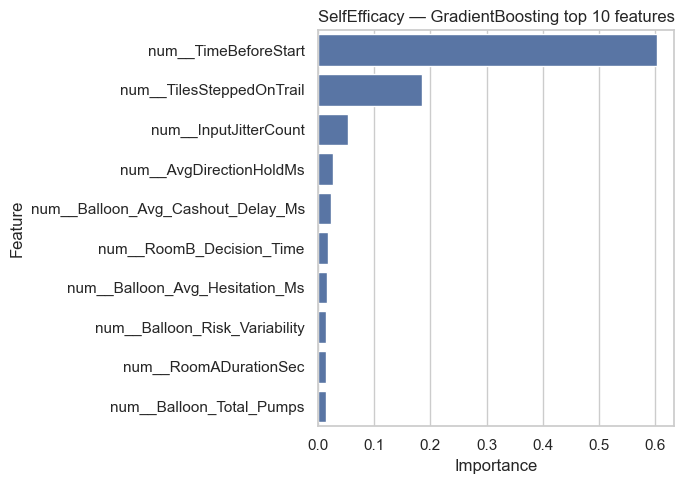

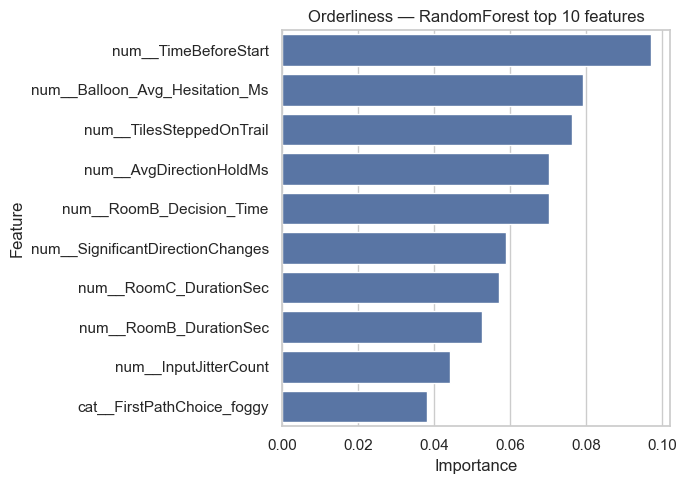

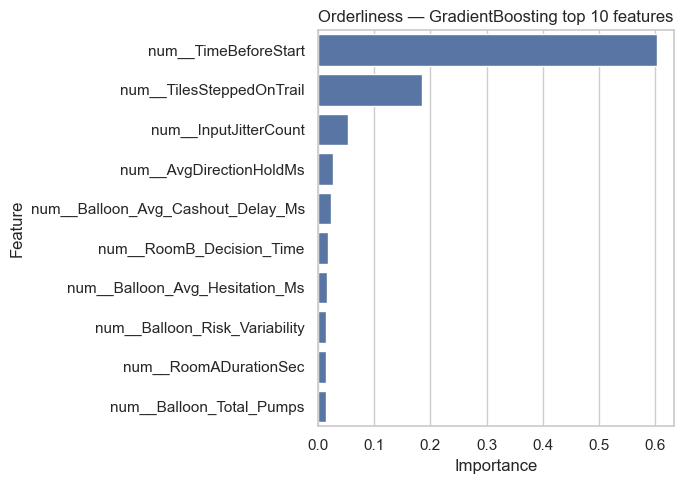

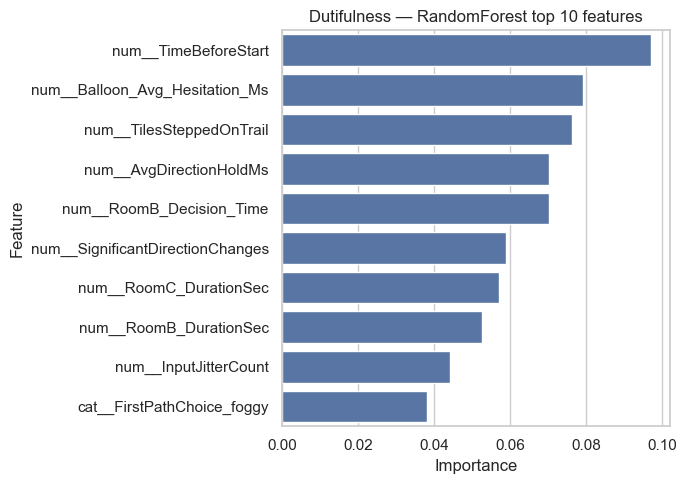

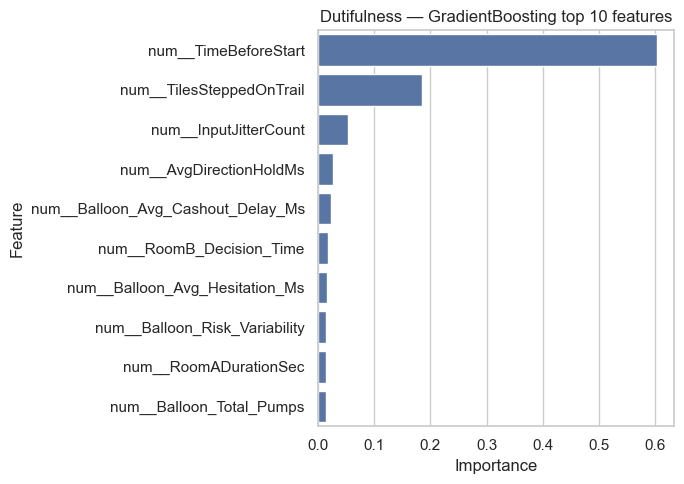

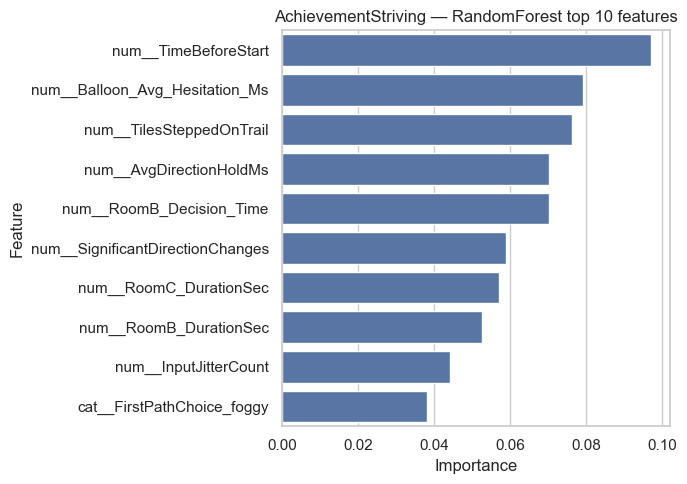

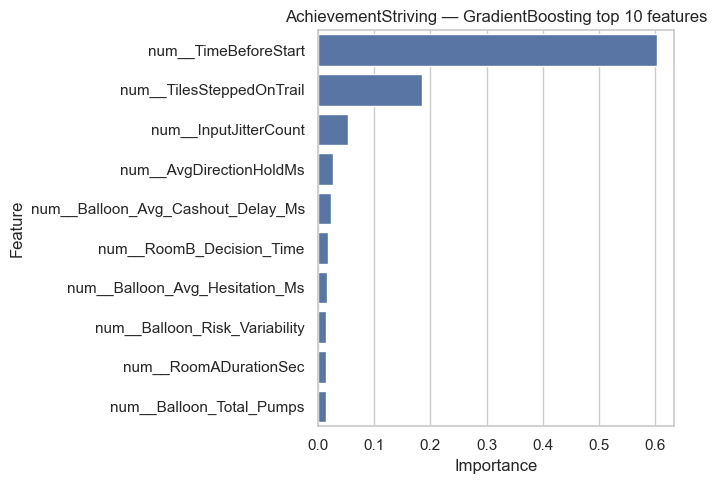

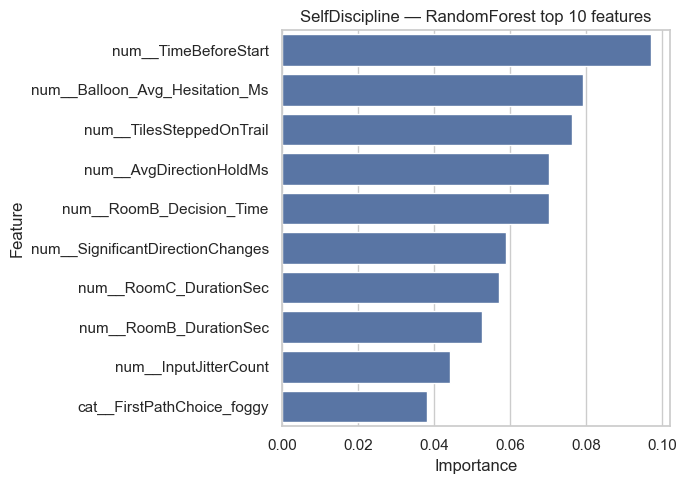

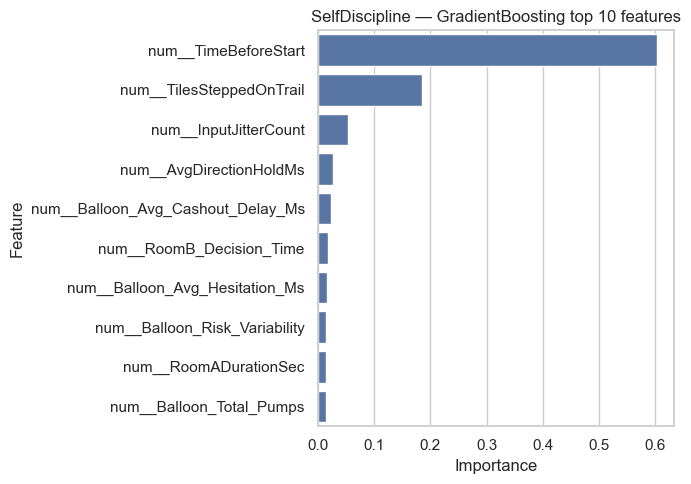

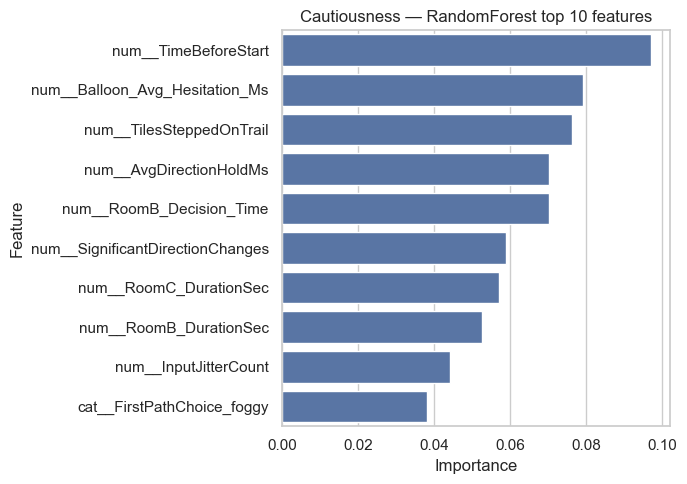

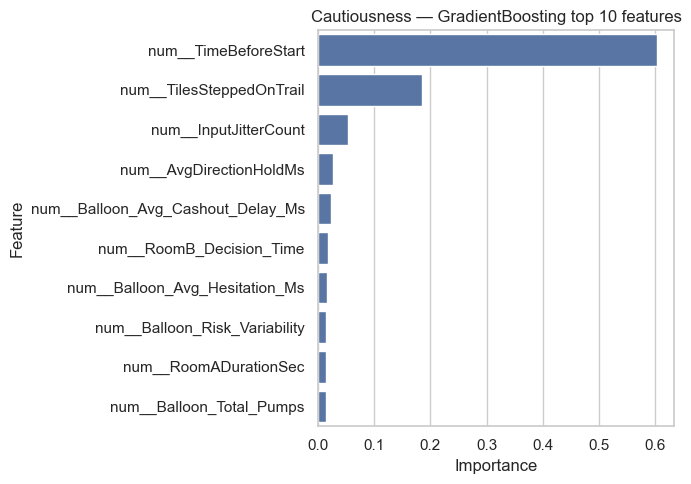

In [35]:
def plot_top_features(facet: str, model_name: str, top_n: int = 10) -> None:
    stored = ml_results.get(facet, {}).get('stored_models', {})
    if model_name not in stored:
        return
    pipeline = stored[model_name]['pipeline']
    model = pipeline.named_steps['model']
    if not hasattr(model, 'feature_importances_'):
        return
    preprocess_step = pipeline.named_steps['preprocess']
    feature_names = preprocess_step.get_feature_names_out()
    importances = pd.Series(model.feature_importances_, index=feature_names).sort_values(ascending=False)
    top = importances.head(top_n)
    plt.figure(figsize=(7, 5))
    sns.barplot(x=top.values, y=top.index, orient='h')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.title(f'{facet} — {model_name} top {top_n} features')
    plt.tight_layout()
    plt.show()

for facet in FACETS:
    for tree_model in ['RandomForest', 'GradientBoosting']:
        plot_top_features(facet, tree_model)


## Block 6 — Final Summary
Summarize rule-based (game) vs. ML errors and show side-by-side visual comparisons for each trait.

In [36]:
if 'rule_facet_df' in globals() and not facet_metrics_df.empty:
    summary = rule_facet_df.merge(facet_metrics_df, on='Facet', how='outer', suffixes=('_rule', '_ml'))
    display(summary.sort_values('MAE_ml'))
else:
    print('Summary unavailable (missing rule or ML metrics).')


,Facet,MAE_rule,RMSE_rule,Model,MAE_ml,RMSE_ml,R2
9,Cheerfulness,3.857143,4.391550,Ridge,0.347471,0.431187,0.814078
21,Modesty,3.571429,4.358899,GradientBoosting,0.605383,0.654393,0.000000
3,Altruism,3.714286,4.208834,GradientBoosting,0.651523,0.869559,-2.024529
4,Anger,1.857143,2.420153,Ridge,0.762955,0.785251,0.725947
7,Assertiveness,3.142857,3.703280,RandomForest,0.775000,1.047688,-3.390600
2,Adventurousness,4.571429,4.840307,RandomForest,0.798333,0.989728,0.020439
29,Vulnerability,2.285714,2.672612,RandomForest,0.958333,1.209768,-0.463539
14,ExcitementSeeking,3.857143,4.326001,GradientBoosting,1.019558,1.141111,0.674467
25,SelfDiscipline,1.857143,2.236068,LinearRegression,1.173869,1.643157,-0.199985
6,ArtisticInterests,4.142857,5.000000,RandomForest,1.176667,1.395365,0.134647


In [42]:
# Visual comparison: Game vs True and ML vs True
for trait in TRAIT_BASE:
    if trait not in ml_results:
        continue

    game_col = TRAIT_TO_GAME[trait]
    true_col = TRAIT_TO_TRUE[trait]
    if game_col not in df.columns or true_col not in df.columns:
        continue

    pair = df[[game_col, true_col]].dropna()
    if pair.empty:
        continue

    best_name = ml_results[trait]['best_model']
    stored = ml_results[trait]['stored_models'].get(best_name) if best_name else None
    if stored is None:
        continue

    y_test = stored['y_test']
    y_pred = stored['y_pred']
    if len(y_test) == 0:
        continue

    fig, axes = plt.subplots(1, 2, figsize=(10, 4), squeeze=False)

    sns.scatterplot(data=pair, x=true_col, y=game_col, ax=axes[0, 0], alpha=0.6, edgecolor='k')
    min_val = min(pair[true_col].min(), pair[game_col].min())
    max_val = max(pair[true_col].max(), pair[game_col].max())
    axes[0, 0].plot([min_val, max_val], [min_val, max_val], 'r--')
    axes[0, 0].set_title(f'Game vs True — {trait}')
    axes[0, 0].set_xlabel(f'True {trait}')
    axes[0, 0].set_ylabel(f'Game {trait}')

    sns.scatterplot(x=y_test, y=y_pred, ax=axes[0, 1], alpha=0.6, edgecolor='k')
    min_val_ml = min(y_test.min(), y_pred.min())
    max_val_ml = max(y_test.max(), y_pred.max())
    axes[0, 1].plot([min_val_ml, max_val_ml], [min_val_ml, max_val_ml], 'r--')
    axes[0, 1].set_title(f'ML ({best_name}) vs True — {trait}')
    axes[0, 1].set_xlabel(f'True {trait}')
    axes[0, 1].set_ylabel(f'Predicted {trait}')

    plt.tight_layout()
    plt.show()
